# Computer-Aided Diagnosis (CAD) of Breast Cancer: Methods of Model Explainability
### Code for training and visualizing deep learning algorithms: CNN, Saliency, TransCAM


# Imports

In [ ]:
# imports
from google.colab import drive
gdrive_path = "/content/gdrive"
drive.mount(gdrive_path, force_remount=False)

import sklearn
import os
import pandas as pd
import numpy as np
import cv2

from fastai.vision import *
from fastai.vision.all import *
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from PIL import Image

! pip install grad_cam
! pip install timm

from pytorch_grad_cam import GradCAM, GradCAMElementWise, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import importlib
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim
from torchvision import transforms

from functools import partial

from timm.models.layers import DropPath, trunc_normal_

Mounted at /content/gdrive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.8 MB 2.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=46dbd02d9cce7099dacc3153ac395a6cba07dd0a8a56d61d5272ee906b4dae0e
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 4.0 MB/s 
     |████████████████████████████████| 182 kB 80.4 MB/s 


# Data Collection

Construct and save dataframe or load existing dataframe

In [ ]:
def is_valid_col(df, stratify_cols, p=0.2):
    # takes a dataframe and list of columns to stratify by
    # returns dataframe with 'is_valid' column according to stratification
    # and test percentage

    # create 'is_valid' col set to False
    df['is_valid'] = False

    # create dummy column for stratification
    df['strat_col'] = ''
    for ii in stratify_cols:
        df['strat_col'] = df['strat_col'] + df[ii]
    
    # split data into train and test dataframes
    train, test = train_test_split(df, test_size=p, stratify=df['strat_col'], random_state=42)

    # change 'is_valid' column in df based on test indices
    df.loc[test.index,"is_valid"] = True

    # drop dummy column and return
    df.drop(columns=['strat_col'], inplace=True)
    return df

Collect image paths and pathologies from public and Mayo datasets into pandas dataframe  
- All images are saved in shared BUS Project Google Drive 

In [ ]:
target_var = "pathology"
datasets_folder = gdrive_path + "/MyDrive/BUS Project Home/Datasets"


# BUS_Dataset_B
# No information on if any images from same patient
bus_b = Path(datasets_folder + "/BUS_Dataset_B")

# Create dictionary of labels given file name
bus_b_labels = pd.read_csv(bus_b / "combined.csv")
bus_b_label_dict = dict(zip(bus_b_labels.Image, bus_b_labels.Type))

bus_b_all_images = [f for f in (bus_b / "original").glob("*")]
bus_b_all_labels = [bus_b_label_dict[f.name] for f in bus_b_all_images]

bus_b_df = pd.DataFrame(
    {
        "dataset": ["BUS_Dataset_B"] * len(bus_b_all_images),
        "image": bus_b_all_images,
        "pathology" : bus_b_all_labels
    }
)

all_bus_df = bus_b_df


# Dataset_BUSI_with_GT
# 780 images from 600 women
# with no external ids, some patients may end up in train and test
busi_gt = Path(datasets_folder + "/Dataset_BUSI_with_GT")

for type in ['benign', 'malignant', 'normal']: # can add normal later if needed
    busi_gt_all_images = [
        f for f in (busi_gt / type).glob("*") if "_mask" not in str(f)
    ]
    busi_gt_all_labels = [type] * len(busi_gt_all_images)

    busi_gt_df = pd.DataFrame(
        {
            "dataset": ["Dataset_BUSI_with_GT"] * len(busi_gt_all_images),
            "image": busi_gt_all_images,
            "pathology": busi_gt_all_labels
        }
    )
    all_bus_df = pd.concat([all_bus_df, busi_gt_df], ignore_index=True)


# BUV dataset
# take every 50th frame from each video - can be changed
def choose_images(folder, n=50):
    """
    given a folder 
    sort files by name
    return every nth file as list
    """
    def last_10chars(x):
        return x[-10:]
    
    all_images = [str(f) for f in folder.glob("*")]
    all_images_sorted = sorted(all_images, key = last_10chars)
    selected_images = all_images_sorted[::n]
    image_paths = [Path(f) for f in selected_images]
    return image_paths

buv = Path(datasets_folder + "/BUV_dataset/rawframes")

for type in ['benign', 'malignant']:
    # create nested list of images from each video folder
    buv_all_images = [choose_images(video) for video in (buv / type).glob('*')]
    buv_all_labels = [type] * len(buv_all_images)

    buv_df = pd.DataFrame(
        {
            "dataset": ["BUV"] * len(buv_all_images),
            "image": buv_all_images,
            "pathology": buv_all_labels
        }
    )
    all_bus_df = pd.concat([all_bus_df, buv_df], ignore_index=True)


# Mayo images
mayo = Path(gdrive_path + "/MyDrive/BUS Project Home/Share_with_group/Jeff_Baggett/Fastai_classify_cam")

# Create dictionary of {file_name : path}
mayo_image_dict = dict([(f.name, f) for f in (mayo / "images_eq").glob("*")])
mayo_df = pd.read_csv(mayo / "labels.csv", usecols=['id', 'filename', 'pathology'])
# Remove a duplicate patient id and images (same images for id 779898672)
mayo_df = mayo_df[mayo_df['id'] != 730768720]
# Create column with image Paths
mayo_df['image'] = mayo_df['filename'].map(mayo_image_dict)
mayo_df.drop(columns='filename', inplace=True)
# Group image paths for same patients
mayo_df = mayo_df.groupby(
        "id", as_index=False
    ).agg(
        {"image": lambda x: list(x), "pathology":'first'}
    ).drop(
        columns='id'
    )
mayo_df['dataset'] = ['Mayo'] * mayo_df.shape[0]
# reorder to align with all_bus_df formatting
mayo_df = mayo_df[['dataset', 'image', 'pathology']]

all_bus_df = pd.concat([all_bus_df, mayo_df], ignore_index=True)

# formatting
all_bus_df['pathology'] = all_bus_df['pathology'].str.lower()

# one-hot encode pathology for TransCAM
one_hot_pathologies = pd.get_dummies(all_bus_df['pathology'])
all_bus_df = all_bus_df.join(one_hot_pathologies)

# assigning validation set
# stratifying by dataset and pathology
stratify_cols = ['dataset', 'pathology']
all_bus_df = is_valid_col(all_bus_df, stratify_cols, p=0.2)

# Images that come from the same patient are currently grouped 
# and  assigned to the same test/train set. 
# Now we explode the dataframe so that each row contains 1 image.

# expand dataframe when patient had multiple images
df = all_bus_df.explode('image').reset_index().drop(columns='index')

**Histogram Equalization of all images**

Uses CLAHE (Contrast Limited Adaptive Histogram Equalization)
[link](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html)

In [ ]:
def hist_equalize(im_path):
    # create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    im_str = str(im_path)
    img = cv2.imread(im_str,0) # in grayscale
    im_eq = clahe.apply(img)
    return im_eq

df['image_arr'] = df['image'].apply(lambda x: hist_equalize(x))

print(df.head())

         dataset  \
0  BUS_Dataset_B   
1  BUS_Dataset_B   
2  BUS_Dataset_B   
3  BUS_Dataset_B   
4  BUS_Dataset_B   

                                                                              image  \
0  /content/gdrive/MyDrive/BUS Project Home/Datasets/BUS_Dataset_B/original/299.png   
1  /content/gdrive/MyDrive/BUS Project Home/Datasets/BUS_Dataset_B/original/300.png   
2  /content/gdrive/MyDrive/BUS Project Home/Datasets/BUS_Dataset_B/original/304.png   
3  /content/gdrive/MyDrive/BUS Project Home/Datasets/BUS_Dataset_B/original/307.png   
4  /content/gdrive/MyDrive/BUS Project Home/Datasets/BUS_Dataset_B/original/302.png   

   pathology  benign  malignant  normal  is_valid  \
0  malignant       0          1       0     False   
1  malignant       0          1       0     False   
2  malignant       0          1       0     False   
3  malignant       0          1       0     False   
4  malignant       0          1       0      True   

                                     

Save dataframe

In [ ]:
df.to_pickle("/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Teresa_Bodart/data/capstone_images.pkl")

Load dataframe (if already saved - histogram equalization can take >30min)

In [ ]:
df = pd.read_pickle("/content/gdrive/MyDrive/BUS Project Home/Share_with_group/Teresa_Bodart/data/capstone_images.pkl")

Remove "normal" image files and one-hot encoded "normal" column

In [ ]:
df.drop(columns=['normal'], inplace=True)
df = df[df['pathology'] != 'normal']
print(df.shape)
print(df.dataset.value_counts())
print(df.pathology.value_counts())
print(df.is_valid.value_counts())
df.head(2)

(1678, 7)
Dataset_BUSI_with_GT    647
BUV                     593
Mayo                    275
BUS_Dataset_B           163
Name: dataset, dtype: int64
benign       923
malignant    755
Name: pathology, dtype: int64
False    1347
True      331
Name: is_valid, dtype: int64


dataset  \
0  BUS_Dataset_B   
1  BUS_Dataset_B   

                                                                              image  \
0  /content/gdrive/MyDrive/BUS Project Home/Datasets/BUS_Dataset_B/original/299.png   
1  /content/gdrive/MyDrive/BUS Project Home/Datasets/BUS_Dataset_B/original/300.png   

   pathology  benign  malignant  is_valid  \
0  malignant       0          1     False   
1  malignant       0          1     False   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 image_arr  
0  [[45, 67, 74, 69, 58, 49, 38, 25, 14, 11, 12, 10, 10, 14, 22, 29, 36, 40, 36, 29, 20, 15, 14, 13, 12, 13, 12, 11, 11, 10, 11, 13, 14, 14, 14, 19, 23, 28, 41, 64, 52, 43, 41, 42, 40, 42, 47, 38, 36, 36, 31, 24, 22, 19, 16, 17, 17, 16, 20, 20, 13, 13, 22, 31, 26, 29, 37, 31, 42, 40, 24, 19, 18, 14, 12, 10, 10, 9, 8, 8, 7, 6, 6, 5, 5, 7, 8, 8, 7, 7, 9, 8, 9, 9, 8, 9, 10, 10, 11, 14, ...], [136, 138, 136, 137, 144, 148, 146, 142, 137, 127, 124, 126, 128, 140, 146, 147, 154, 154, 143, 134, 128, 126, 128, 124, 120, 122, 120, 110, 105, 115, 115, 115, 117, 114, 116, 129, 140, 147, 155, 164, 164, 1...  
1  [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 255, 255, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 255, 255, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 255, 255, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 255, 255, 2, 2, 2, 2, 2, 2...

# Train Models

## Setup fast.ai Datablock and Dataloader for Basic CNN and Saliency Model

In the next cell we set up a datablock that tells fastai how to load the data, where to get the images and the labels, how to split the data into training and validation sets, and what augmentations to use.  Random cropping that contains at least 80% of the original image is used for augmentation (and MixUp which is added later). The normalize_from_stats transform makes our images have the same mean and standard deviation as imagenet images.

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks')
path = Path(os.getcwd())

target_var = 'pathology'

blocks = (ImageBlock(cls=PILImageBW), CategoryBlock)
getters = [
    # histogram equalized image arrays
    # use 'image' for file paths of original images
    ColReader("image_arr"),  
    ColReader(target_var)
]

batch_tfms = Normalize.from_stats(*imagenet_stats)
item_tfms = [FlipItem(),RandomResizedCrop(256,min_scale=0.8)]

dblock = DataBlock(blocks       = blocks,
                   getters      = getters,
                   splitter     = ColSplitter(),
                   batch_tfms   = batch_tfms,
                   item_tfms    = item_tfms)

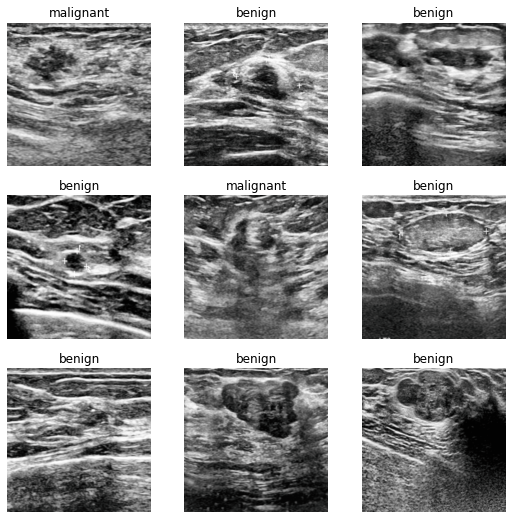

In [ ]:
dls = dblock.dataloaders(df)
dls.show_batch()

In [ ]:
dls.train.drop_last = False # don't drop last

Example of data augmentations on a single image

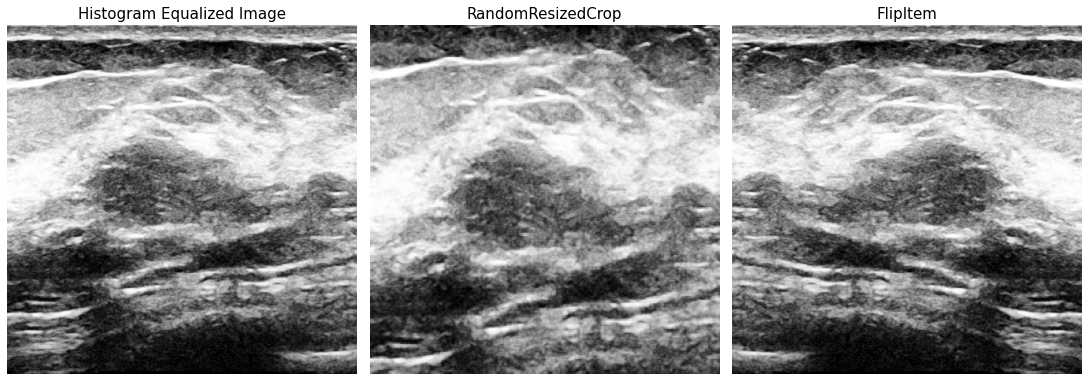

In [ ]:
img_path = df.iloc[1610, 1]
img = transforms.ToTensor()(Image.open(img_path).convert("RGB"))

flip_img = transforms.RandomHorizontalFlip(p=0.5)(img)
crop_img = transforms.RandomResizedCrop(size=(256,256), scale=(0.8, 0.8))(img)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,15), squeeze=False, constrained_layout=True)

axs[0,0].imshow(np.asarray(img.permute(1,2,0)))
axs[0,0].set_title('Histogram Equalized Image', fontsize=15)
axs[0,0].axis("off")

axs[0,1].imshow(np.asarray(crop_img.permute(1,2,0)))
axs[0,1].set_title('RandomResizedCrop', fontsize=15)
axs[0,1].axis("off")

axs[0,2].imshow(np.asarray(flip_img.permute(1,2,0)))
axs[0,2].set_title('FlipItem', fontsize=15)
axs[0,2].axis("off");

The labels are imbalanced so we use scikit-learn to compute class weights.  These weights are passed to the loss function in fastai.

In [ ]:
# compute class weights to counter data imbalance, if any

y = df[target_var].tolist()
classes = np.unique(y)
w = torch.FloatTensor(
    compute_class_weight("balanced",classes=classes,y=y)
    ).cuda()

print('classes:',classes)
print('weights:',w)

classes: ['benign' 'malignant']
weights: tensor([0.9090, 1.1113], device='cuda:0')


## Train Basic CNN Model

Now we define the learner.  Here we're using a pretrained resnet34 model and adding an accuracy metric that will be displayed in the training process.

In [ ]:
base_model_cam = resnet34
learn_cam = vision_learner(dls, base_model_cam, 
                           loss_func = CrossEntropyLossFlat(weight = w), 
                           metrics=accuracy) #assumes pretrained

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

This will train on minibatches to estimate a good learning rate.  This is a bit slow, so you can hardwire the learning rate after you've run this once.

SuggestedLRs(valley=0.0010000000474974513)

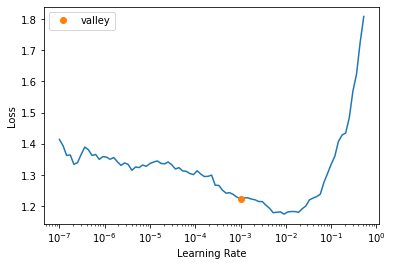

In [ ]:
learn_cam.lr_find()

Now we'll train for a few epochs with the selected learning rate.  At this point all of the convolution layers are frozen so we are just training the fully connected layers in the "head" of the network.  The MixUp() augmentations are important to prevent overfitting with such a small dataset.

In [ ]:
#lr = learn.lr
lr_cam = 0.001
learn_cam.fit_one_cycle(10,lr_cam,cbs = MixUp())

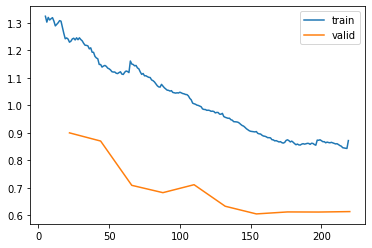

In [ ]:
learn_cam.recorder.plot_loss()

After 10 epochs we see that both the training and validation loss are decreasing together so we'll unfreeze the body of the network and train all the layers.  We are using discrimative learning rates (for pretrained models, not sure about the best practice when training from scratch) which means smaller learning rates for earlier levels. 

Now unfreeze all the layers and train for X cycles.  The deepest layers get the smallest learning rates.

In [ ]:
learn_cam.unfreeze()

A "rule-of-thumb" is to choose the rates to be from lr/400 to lr/4 after unfreezing.  You could also run the learning rate finder again but we've found that it isn't necessary.  The `SaveModelCallback` callback below ensure that we save the model everytime there is an improvement in accuracy of at least `min_delta`.  The `EarlyStoppingCallback` stops training when there has no improvement in accuracy for `patience` number of epochs.  

We have to run for a lot of epochs because training with MixUp is slow.  We could use far fewer epochs without MixUp but we'd have overfitting problems without MixUp.  Another approach would be to use self-supervised learning to do pre-training and then fine tune all of the layers for a few epochs.  

In [ ]:
# these are the learning rates determined from lr_find hardwired for speed.
#lr = learn.lr

callbacks_cam = [
    EarlyStoppingCallback(monitor='accuracy', min_delta=0.005, patience=100),
    SaveModelCallback(monitor='accuracy', min_delta=0.005),
    MixUp()
]

learn_cam.fit_one_cycle(500,lr_max=slice(lr_cam/400,lr_cam/4),cbs=callbacks_cam)

Better model found at epoch 0 with accuracy value: 0.7039275169372559.
Better model found at epoch 20 with accuracy value: 0.7099697589874268.
Better model found at epoch 22 with accuracy value: 0.7220543622970581.
Better model found at epoch 28 with accuracy value: 0.7280966639518738.
Better model found at epoch 58 with accuracy value: 0.7401812672615051.
Better model found at epoch 65 with accuracy value: 0.7522658705711365.
Better model found at epoch 74 with accuracy value: 0.7583081722259521.
Better model found at epoch 75 with accuracy value: 0.7643504738807678.
Better model found at epoch 78 with accuracy value: 0.7794561982154846.
Better model found at epoch 82 with accuracy value: 0.7854984998703003.
Better model found at epoch 83 with accuracy value: 0.791540801525116.
Better model found at epoch 86 with accuracy value: 0.7975831031799316.
Better model found at epoch 88 with accuracy value: 0.8126888275146484.
Better model found at epoch 134 with accuracy value: 0.82175225019

Your trained model should have around 80% to 90% accuracy on the validation set.  We can visualize the loss function history to see if the model seems converged.  If the validation loss flattens but the training loss continues to decrease, then it's likely overfitting.  We can visualize the training history like this:

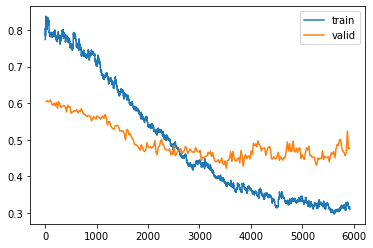

In [ ]:
learn_cam.recorder.plot_loss()

Note that the last third or so of the graph is essentially flat so we're unlikely to gain anything by further fitting.  There's also a sizeable gap between the validation and training loss which suggests some overfitting.

Now let's see the confusion matrix and also plot images corresponding to the misclassified lesions with the largest losses (errors).

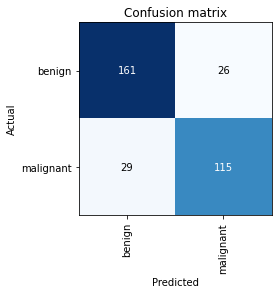

In [ ]:
interp_cam = ClassificationInterpretation.from_learner(learn_cam)
interp_cam.plot_confusion_matrix()

Most the trouble seems to be that we are misclassifying many of the malignant images as benign.  Let's see which images are giving us the most trouble:

Having opposite problem with lr 0.001

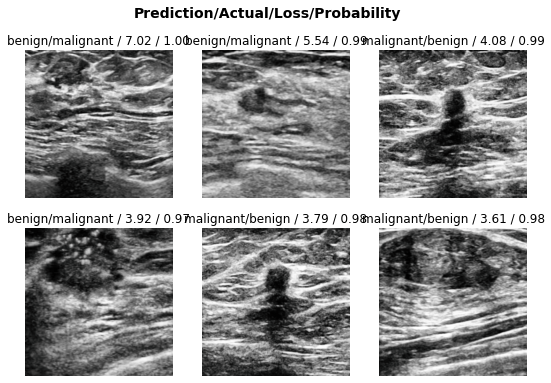

In [ ]:
interp_cam.plot_top_losses(6)

Save model in current path

In [ ]:
learn_cam.save('basic_cnn', with_opt=True)

Path('models/basic_cnn.pth')

## Train Saliency Model
Train with and without L1 penalty term (*lambda* = 0.01 and *lambda* = 0, respectively)

In [ ]:
class SaliencyModel(nn.Module):
    """
    Creates a saliency map model with the encoder from "arch" 
    and with dropout multiplier ps.
    """
    def __init__(self, arch,ps=0.5, percent_t = 0.05):
        super(SaliencyModel,self).__init__()
        # fastai function that creates an encoder given an architecture
        self.encoder = create_body(arch,pretrained=True)  
        self.percent_t = percent_t
        nf = num_features_model(nn.Sequential(*self.encoder.children()))
        # Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.conv_last = nn.Conv2d( nf, 2, (1,1), bias = False) 

    def forward(self,x):
        # apply the base convolutional nn to 
        # convert image 1 x H x W  (e.g. 1 x 256 x 256)
        # to feature map C x h x w (e.g. 512 x 8 x 8 )
        x = self.encoder(x)

        # for each possible classification label take a weighted average of 
        # the C features and apply sigmoid to produce a saliency map that will
        # be 1 x h x w
        cam = self.conv_last(x).sigmoid()
        self.saliency_map = cam
        batch_size, num_class, H, W = cam.size()

        # use Wildcat pooling to average the top t percent of the pixels in the
        # saliency map to a single number for prediction
        # do this for each of the possible classes.  
        # If t = 100% this is GAP.  
        # If t = 100*(1/(h*w)) we get one pixel and this is GMP.
        cam_flatten = cam.view(batch_size, num_class, -1)
        top_t = int(round(W*H*self.percent_t))
        selected_area = cam_flatten.topk(top_t, dim=2)[0]
        return selected_area.mean(dim=2).squeeze()

# The regularization term |A| is model.saliency_maps.mean()
class L1RegCallback(Callback):
    def __init__(self, reglambda = 0.01):
        self.reglambda = reglambda
        
    def after_loss(self):
        self.learn.loss += self.reglambda * self.learn.model.saliency_map.mean()

### Saliency Model with L1 Regularization

In [ ]:
base_model_saliency = SaliencyModel(resnet34()).cuda()
learn_saliency_L1 = Learner(dls, 
                         base_model_saliency, 
                         loss_func = CrossEntropyLossFlat(weight = w), 
                         metrics = accuracy, 
                         cbs = [L1RegCallback()])

SuggestedLRs(valley=0.0005754399462603033)

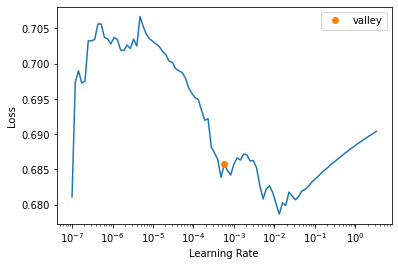

In [ ]:
learn_saliency_L1.lr_find()

In [ ]:
#lr = learn.lr
lr_saliency = 0.0005
learn_saliency_L1.fit_one_cycle(10,lr_saliency, cbs = [L1RegCallback(), MixUp()])

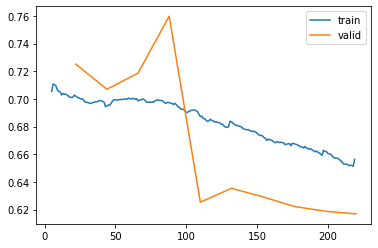

In [ ]:
learn_saliency_L1.recorder.plot_loss()

Now unfreeze all the layers and train for up to 500 cycles.  The deepest layers get the smallest learning rates.

In [ ]:
learn_saliency_L1.unfreeze()

In [ ]:
use_mixup = True

callbacks_saliency = [
    EarlyStoppingCallback(monitor='accuracy', min_delta=0.005, patience=100),
    SaveModelCallback(monitor='accuracy', min_delta=0.005),
    L1RegCallback()
]

if use_mixup:
    callbacks_saliency.append(MixUp())

learn_saliency_L1.fit_one_cycle(500, lr_max = slice(lr_saliency/400,lr_saliency/4), cbs = callbacks_saliency)

Better model found at epoch 0 with accuracy value: 0.6676737070083618.
Better model found at epoch 2 with accuracy value: 0.6797583103179932.
Better model found at epoch 4 with accuracy value: 0.69486403465271.
Better model found at epoch 10 with accuracy value: 0.7009063363075256.
Better model found at epoch 18 with accuracy value: 0.7069486379623413.
Better model found at epoch 22 with accuracy value: 0.7220543622970581.
Better model found at epoch 29 with accuracy value: 0.7280966639518738.
Better model found at epoch 30 with accuracy value: 0.7401812672615051.
Better model found at epoch 56 with accuracy value: 0.7462235689163208.
Better model found at epoch 86 with accuracy value: 0.7583081722259521.
Better model found at epoch 140 with accuracy value: 0.7643504738807678.
Better model found at epoch 148 with accuracy value: 0.7764350175857544.
Better model found at epoch 180 with accuracy value: 0.7824773192405701.
No improvement since epoch 180: early stopping


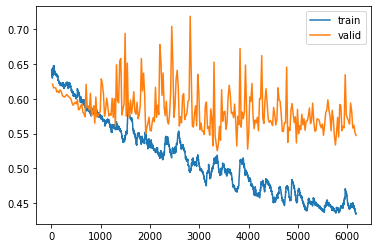

In [ ]:
learn_saliency_L1.recorder.plot_loss()

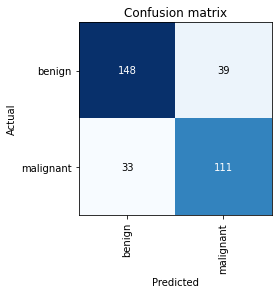

In [ ]:
interp_saliency_L1 = ClassificationInterpretation.from_learner(learn_saliency_L1)
interp_saliency_L1.plot_confusion_matrix()

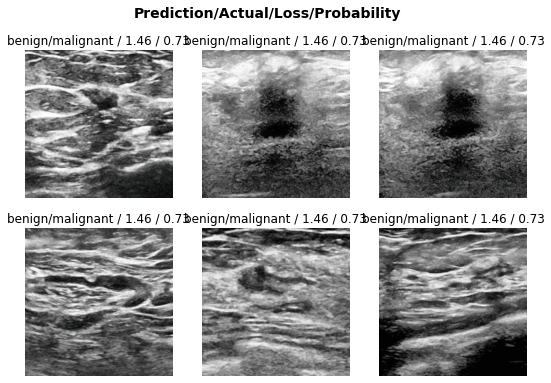

In [ ]:
interp_saliency_L1.plot_top_losses(6)

Save model

In [ ]:
learn_saliency_L1.save('saliency_model_L1',with_opt=True)

Path('models/saliency_model_L1.pth')

### Saliency Model without L1 Regularization

In [ ]:
base_model_saliency = SaliencyModel(resnet34()).cuda()
learn_saliency = Learner(dls, 
                         base_model_saliency, 
                         loss_func = CrossEntropyLossFlat(weight = w), 
                         metrics = accuracy, 
                         cbs = [L1RegCallback(reglambda=0)])

SuggestedLRs(valley=0.0006918309954926372)

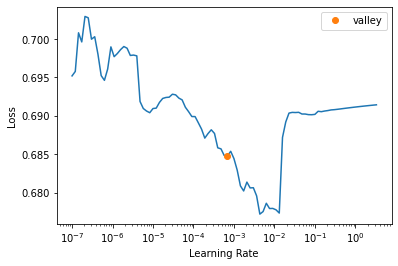

In [ ]:
learn_saliency.lr_find()

In [ ]:
lr_saliency = 0.0005
learn_saliency.fit_one_cycle(10,lr_saliency, cbs = [L1RegCallback(reglambda=0), MixUp()])

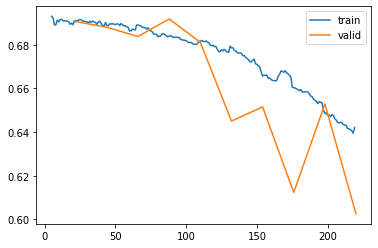

In [ ]:
learn_saliency.recorder.plot_loss()

Now unfreeze all the layers and train for up to 500 cycles.  The deepest layers get the smallest learning rates.

In [ ]:
learn_saliency.unfreeze()

In [ ]:
use_mixup = True

callbacks_saliency = [
    EarlyStoppingCallback(monitor='accuracy', min_delta=0.005, patience=100),
    SaveModelCallback(monitor='accuracy', min_delta=0.005),
    L1RegCallback(reglambda=0)
]

if use_mixup:
    callbacks_saliency.append(MixUp())

learn_saliency.fit_one_cycle(500, lr_max = slice(lr_saliency/400,lr_saliency/4), cbs = callbacks_saliency)

Better model found at epoch 0 with accuracy value: 0.6918429136276245.
Better model found at epoch 9 with accuracy value: 0.7039275169372559.
Better model found at epoch 27 with accuracy value: 0.7160120606422424.
Better model found at epoch 98 with accuracy value: 0.7250755429267883.
Better model found at epoch 131 with accuracy value: 0.7371601462364197.
Better model found at epoch 141 with accuracy value: 0.7492446899414062.
Better model found at epoch 169 with accuracy value: 0.7552869915962219.
Better model found at epoch 240 with accuracy value: 0.7673715949058533.
Better model found at epoch 242 with accuracy value: 0.7824773192405701.
No improvement since epoch 242: early stopping


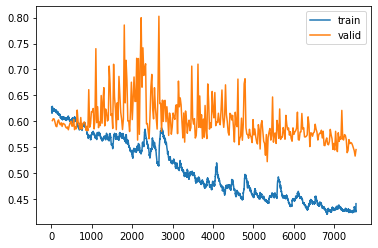

In [ ]:
learn_saliency.recorder.plot_loss()

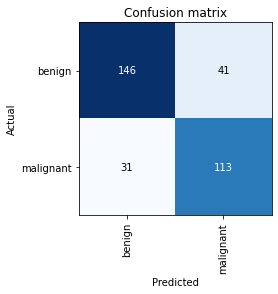

In [ ]:
interp_saliency = ClassificationInterpretation.from_learner(learn_saliency)
interp_saliency.plot_confusion_matrix()

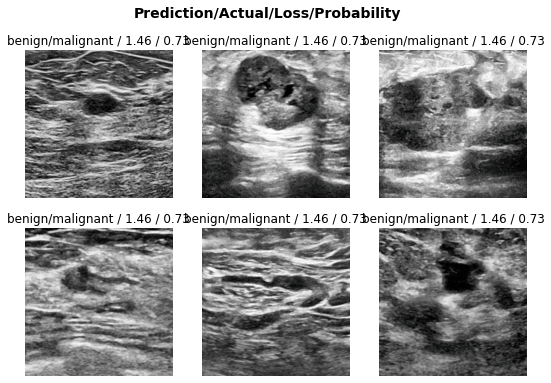

In [ ]:
interp_saliency.plot_top_losses(6)

Save model

In [ ]:
learn_saliency.save('saliency_model',with_opt=True)

Path('models/saliency_model.pth')

## Train TransCAM
Adapted from [TransCAM](https://github.com/liruiwen/TransCAM)

Custom dataloader for pandas df

In [ ]:
target_var = 'pathology'

cat_list = ['benign', 'malignant'] # classes using one-hot encoded columns

cat_name_to_num = dict(zip(cat_list,range(len(cat_list)))) 
cat_num_to_name = {v: k for k, v in cat_name_to_num.items()}

def grayscale_to_rgb(image_array):
    # takes histogram equalized grayscale numpy arrays of images
    # returns 3-channel version
    rgb_im_eq = np.stack((image_array,)*3, axis=-1)
    return rgb_im_eq

class BUSDataset(Dataset): 
    # custom Dataset to return files in same format as paper: 
    # images in RGB and labels as tensors
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_path = str(row['image'])
        img = grayscale_to_rgb(row['image_arr'])
        img = Image.fromarray(img, mode="RGB")
        label = cat_name_to_num[row[target_var]]
        label_tensor = torch.from_numpy(np.array([label]))

        if self.transform is not None:
            img = self.transform(img)

        return img_path, img, label_tensor

### `conformer.py`

In [ ]:
# -----------------------------------------------------------------------------------------------------
# TS-CAM using Conformer as backbone is implemented based on https://github.com/pengzhiliang/Conformer
# -----------------------------------------------------------------------------------------------------

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)


    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x, attn

class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        y, attn_weight = self.attn(self.norm1(x))
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x, attn_weight

class ConvBlock(nn.Module):

    def __init__(self, inplanes, outplanes, stride=1, res_conv=False, act_layer=nn.ReLU, groups=1,
                 norm_layer=partial(nn.BatchNorm2d, eps=1e-6), drop_block=None, drop_path=None):
        super(ConvBlock, self).__init__()

        expansion = 4
        med_planes = outplanes // expansion

        self.conv1 = nn.Conv2d(inplanes, med_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = norm_layer(med_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(med_planes, med_planes, kernel_size=3, stride=stride, groups=groups, padding=1, bias=False)
        self.bn2 = norm_layer(med_planes)
        self.act2 = act_layer(inplace=True)

        self.conv3 = nn.Conv2d(med_planes, outplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = norm_layer(outplanes)
        self.act3 = act_layer(inplace=True)

        if res_conv:
            self.residual_conv = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=stride, padding=0, bias=False)
            self.residual_bn = norm_layer(outplanes)

        self.res_conv = res_conv
        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x, x_t=None, return_x_2=True):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x) if x_t is None else self.conv2(x + x_t)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x2 = self.act2(x)

        x = self.conv3(x2)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        if self.res_conv:
            residual = self.residual_conv(residual)
            residual = self.residual_bn(residual)

        x += residual
        x = self.act3(x)

        if return_x_2:
            return x, x2
        else:
            return x


class FCUDown(nn.Module):
    """ CNN feature maps -> Transformer patch embeddings
    """

    def __init__(self, inplanes, outplanes, dw_stride, act_layer=nn.GELU,
                 norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super(FCUDown, self).__init__()
        self.dw_stride = dw_stride

        self.conv_project = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0)
        self.sample_pooling = nn.AvgPool2d(kernel_size=dw_stride, stride=dw_stride)

        self.ln = norm_layer(outplanes)
        self.act = act_layer()

    def forward(self, x, x_t):
        x = self.conv_project(x)  # [N, C, H, W]

        x = self.sample_pooling(x).flatten(2).transpose(1, 2)
        x = self.ln(x)
        x = self.act(x)

        x = torch.cat([x_t[:, 0][:, None, :], x], dim=1)

        return x


class FCUUp(nn.Module):
    """ Transformer patch embeddings -> CNN feature maps
    """

    def __init__(self, inplanes, outplanes, up_stride, act_layer=nn.ReLU,
                 norm_layer=partial(nn.BatchNorm2d, eps=1e-6),):
        super(FCUUp, self).__init__()

        self.up_stride = up_stride
        self.conv_project = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0)
        self.bn = norm_layer(outplanes)
        self.act = act_layer()

    def forward(self, x, H, W):
        B, _, C = x.shape
        # [N, 197, 384] -> [N, 196, 384] -> [N, 384, 196] -> [N, 384, 14, 14]
        x_r = x[:, 1:].transpose(1, 2).reshape(B, C, H, W)
        x_r = self.act(self.bn(self.conv_project(x_r)))

        return F.interpolate(x_r, size=(H * self.up_stride, W * self.up_stride))


class Med_ConvBlock(nn.Module):
    """ special case for Convblock with down sampling,
    """
    def __init__(self, inplanes, act_layer=nn.ReLU, groups=1, norm_layer=partial(nn.BatchNorm2d, eps=1e-6),
                 drop_block=None, drop_path=None):

        super(Med_ConvBlock, self).__init__()

        expansion = 4
        med_planes = inplanes // expansion

        self.conv1 = nn.Conv2d(inplanes, med_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = norm_layer(med_planes)
        self.act1 = act_layer(inplace=True)

        self.conv2 = nn.Conv2d(med_planes, med_planes, kernel_size=3, stride=1, groups=groups, padding=1, bias=False)
        self.bn2 = norm_layer(med_planes)
        self.act2 = act_layer(inplace=True)

        self.conv3 = nn.Conv2d(med_planes, inplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = norm_layer(inplanes)
        self.act3 = act_layer(inplace=True)

        self.drop_block = drop_block
        self.drop_path = drop_path

    def zero_init_last_bn(self):
        nn.init.zeros_(self.bn3.weight)

    def forward(self, x):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        if self.drop_block is not None:
            x = self.drop_block(x)

        if self.drop_path is not None:
            x = self.drop_path(x)

        x += residual
        x = self.act3(x)

        return x


class ConvTransBlock(nn.Module):
    """
    Basic module for ConvTransformer, keep feature maps for CNN block and patch embeddings for transformer encoder block
    """

    def __init__(self, inplanes, outplanes, res_conv, stride, dw_stride, embed_dim, num_heads=12, mlp_ratio=4.,
                 qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.,
                 last_fusion=False, num_med_block=0, groups=1):

        super(ConvTransBlock, self).__init__()
        expansion = 4
        self.cnn_block = ConvBlock(inplanes=inplanes, outplanes=outplanes, res_conv=res_conv, stride=stride, groups=groups)

        if last_fusion:
            self.fusion_block = ConvBlock(inplanes=outplanes, outplanes=outplanes, stride=1, res_conv=True, groups=groups)
        else:
            self.fusion_block = ConvBlock(inplanes=outplanes, outplanes=outplanes, groups=groups)

        if num_med_block > 0:
            self.med_block = []
            for i in range(num_med_block):
                self.med_block.append(Med_ConvBlock(inplanes=outplanes, groups=groups))
            self.med_block = nn.ModuleList(self.med_block)

        self.squeeze_block = FCUDown(inplanes=outplanes // expansion, outplanes=embed_dim, dw_stride=dw_stride)

        self.expand_block = FCUUp(inplanes=embed_dim, outplanes=outplanes // expansion, up_stride=dw_stride)

        self.trans_block = Block(
            dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=drop_path_rate)

        self.dw_stride = dw_stride
        self.embed_dim = embed_dim
        self.num_med_block = num_med_block
        self.last_fusion = last_fusion

    def forward(self, x, x_t):
        x, x2 = self.cnn_block(x)

        _, _, H, W = x2.shape

        x_st = self.squeeze_block(x2, x_t)

        x_t, attn_weight = self.trans_block(x_st + x_t)

        if self.num_med_block > 0:
            for m in self.med_block:
                x = m(x)

        x_t_r = self.expand_block(x_t, H // self.dw_stride, W // self.dw_stride)
        x = self.fusion_block(x, x_t_r, return_x_2=False)

        return x, x_t, attn_weight


class Net(nn.Module):

    def __init__(self, patch_size=16, in_chans=3, num_classes=1000, base_channel=64, channel_ratio=4, num_med_block=0,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.):

        # Transformer
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        assert depth % 3 == 0

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.trans_dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule

        # Classifier head
        self.trans_norm = nn.LayerNorm(embed_dim)
        self.trans_cls_head = nn.Linear(embed_dim, self.num_classes)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.conv_cls_head = nn.Conv2d(int(256 * channel_ratio), self.num_classes, kernel_size=3, stride=1, padding=1)

        # Stem stage: get the feature maps by conv block (copied form resnet.py)
        self.conv1 = nn.Conv2d(in_chans, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1 / 2 [112, 112]
        self.bn1 = nn.BatchNorm2d(64)
        self.act1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 1 / 4 [56, 56]

        # 1 stage
        stage_1_channel = int(base_channel * channel_ratio)
        trans_dw_stride = patch_size // 4
        self.conv_1 = ConvBlock(inplanes=64, outplanes=stage_1_channel, res_conv=True, stride=1)
        self.trans_patch_conv = nn.Conv2d(64, embed_dim, kernel_size=trans_dw_stride, stride=trans_dw_stride, padding=0)
        self.trans_1 = Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                             qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate, drop_path=self.trans_dpr[0],
                             )

        # 2~4 stage
        init_stage = 2
        fin_stage = depth // 3 + 1
        for i in range(init_stage, fin_stage):
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        stage_1_channel, stage_1_channel, False, 1, dw_stride=trans_dw_stride, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block
                    )
            )


        stage_2_channel = int(base_channel * channel_ratio * 2)
        # 5~8 stage
        init_stage = fin_stage # 5
        fin_stage = fin_stage + depth // 3 # 9
        for i in range(init_stage, fin_stage):
            s = 2 if i == init_stage else 1
            in_channel = stage_1_channel if i == init_stage else stage_2_channel
            res_conv = True if i == init_stage else False
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        in_channel, stage_2_channel, res_conv, s, dw_stride=trans_dw_stride // 2, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block
                    )
            )

        stage_3_channel = int(base_channel * channel_ratio * 2 * 2)
        # 9~12 stage
        init_stage = fin_stage  # 9
        fin_stage = fin_stage + depth // 3  # 13
        for i in range(init_stage, fin_stage):
            s = 2 if i == init_stage else 1
            in_channel = stage_2_channel if i == init_stage else stage_3_channel
            res_conv = True if i == init_stage else False
            last_fusion = True if i == depth else False
            self.add_module('conv_trans_' + str(i),
                    ConvTransBlock(
                        in_channel, stage_3_channel, res_conv, s, dw_stride=trans_dw_stride // 4, embed_dim=embed_dim,
                        num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                        drop_rate=drop_rate, attn_drop_rate=attn_drop_rate, drop_path_rate=self.trans_dpr[i-1],
                        num_med_block=num_med_block, last_fusion=last_fusion
                    )
            )
        self.fin_stage = fin_stage

        trunc_normal_(self.cls_token, std=.02)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)
        elif isinstance(m, nn.GroupNorm):
            nn.init.constant_(m.weight, 1.)
            nn.init.constant_(m.bias, 0.)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'cls_token'}


    def forward(self, method, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        # pdb.set_trace()
        # stem stage [N, 3, 224, 224] -> [N, 64, 56, 56]
        x_base = self.maxpool(self.act1(self.bn1(self.conv1(x))))

        attn_weights = []

        # 1 stage
        x = self.conv_1(x_base, return_x_2=False)

        x_t = self.trans_patch_conv(x_base).flatten(2).transpose(1, 2)
        x_t = torch.cat([cls_tokens, x_t], dim=1)
        x_t, attn_weight = self.trans_1(x_t)
        attn_weights.append(attn_weight)

        # 2 ~ final
        for i in range(2, self.fin_stage):
            x, x_t, attn_weight = eval('self.conv_trans_' + str(i))(x, x_t)
            attn_weights.append(attn_weight)

        # conv classification
        x_conv = self.conv_cls_head(x)
        conv_cls = self.pooling(x_conv).flatten(1)

        # trans classification
        x_t = self.trans_norm(x_t)

        x_patch = x_t[:, 1:]
        n, p, c = x_patch.shape
        x_patch = torch.reshape(x_patch, [n, int(p ** 0.5), int(p ** 0.5), c])
        x_patch = x_patch.permute([0, 3, 1, 2]).contiguous()
        conv_logits = conv_cls
        trans_logits = self.trans_cls_head(x_t[:, 0])

        attn_weights = torch.stack(attn_weights)
        attn_weights = torch.mean(attn_weights, dim=2)  # 12 * B * N * N
        feature_map = x_patch.detach().clone()    # B * C * 14 * 14
        n, c, h, w = feature_map.shape
        attn_weights_no_cls = attn_weights.sum(0)[:, 1:, 1:]
        conv_flat = x_conv.flatten(start_dim=2)

        if method == 'convcam':
            cams = x_conv

        if method == 'clsattn':
            cams = attn_weights.sum(0)[:, 0, 1:].reshape([n, h, w]).unsqueeze(1) * x_conv

        if method == 'transcam':
            cams = torch.einsum('nhw,ncw->nch', attn_weights_no_cls, conv_flat).reshape([n, 2, h, w])  ## 2 = num_classes

        if method == 'attnagg':
            cams = torch.einsum('nhw,ncw->nch', attn_weights_no_cls.transpose(1, 2), conv_flat).reshape([n, 2, h, w])

        return conv_logits, trans_logits, cams


### `conformer_CAM.py`

In [ ]:
np.set_printoptions(threshold=np.inf)

num_classes = 2

class Net_ti(Net):
    def __init__(self):
        super(Net_ti, self).__init__(patch_size=16, channel_ratio=1, embed_dim=384, depth=12,
                      num_heads=6, mlp_ratio=4, qkv_bias=True, drop_rate=0.0, drop_path_rate=0.1, num_classes=num_classes) ##

class Net_sm(Net):
    def __init__(self):
        super(Net_sm, self).__init__(patch_size=16, channel_ratio=4, embed_dim=384, depth=12,
                      num_heads=6, mlp_ratio=4, qkv_bias=True, drop_rate=0.0, drop_path_rate=0.1, num_classes=num_classes) ##

class Net_bs(Net):
    def __init__(self):
        super(Net_bs, self).__init__(patch_size=16, channel_ratio=6, embed_dim=576, depth=12,
                      num_heads=9, mlp_ratio=4, qkv_bias=True, drop_rate=0.0, drop_path_rate=0.1, num_classes=num_classes) ##

### `train_TransCAM.py`

In [ ]:
class AverageMeter:
    def __init__(self, *keys):
        self.__data = dict()
        for k in keys:
            self.__data[k] = [0.0, 0]

    def add(self, dict):
        for k, v in dict.items():
            self.__data[k][0] += v
            self.__data[k][1] += 1

    def get(self, *keys):
        if len(keys) == 1:
            return self.__data[keys[0]][0] / self.__data[keys[0]][1]
        else:
            v_list = [self.__data[k][0] / self.__data[k][1] for k in keys]
            return tuple(v_list)

    def pop(self, key=None):
        if key is None:
            for k in self.__data.keys():
                self.__data[k] = [0.0, 0]
        else:
            v = self.get(key)
            self.__data[key] = [0.0, 0]
            return v

In [ ]:
batch_size = 8
max_epoches = 20
lr = 5e-5
num_workers = 0
wt_dec = 5e-4
arch = Net_sm()
session_name = "TransCAM_multilabel_cross_entropy"
crop_size = 512
weights = 'Conformer_small_patch16.pth' # weights downloaded from Conformer https://github.com/pengzhiliang/Conformer
save_dir = path


model = arch

train_df = df[df['is_valid'] == False]

# ImageNet mean and std for Normalize
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Same transforms as CNN
train_dataset = BUSDataset(train_df,
                           transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomResizedCrop(256,scale=(0.8,1.0))
                           ]))

train_data_loader = DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=0, pin_memory=True, drop_last=True)

# AdamW Optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wt_dec, eps=1e-8)

checkpoint = torch.load(weights, map_location='cpu')
if 'model' in checkpoint.keys():
    checkpoint = checkpoint['model']
else:
    checkpoint = checkpoint
model_dict = model.state_dict()
for k in ['trans_cls_head.weight', 'trans_cls_head.bias']:
    print(f"Removing key {k} from pretrained checkpoint")
    del checkpoint[k]
for k in ['conv_cls_head.weight', 'conv_cls_head.bias']:
    print(f"Removing key {k} from pretrained checkpoint")
    del checkpoint[k]
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

model = torch.nn.DataParallel(model).cuda()
model.train()

avg_meter = AverageMeter('loss')

for ep in range(max_epoches):
    for iter, pack in enumerate(train_data_loader):
        img_path, img, label = pack  ## my dataset returns img_path, img, label
        N, C, H, W = img.size()  # N = batch size, C = color channels, H = height, and W = width
        bg_score = torch.ones((N, 1))
        label = torch.cat((bg_score, label), dim=1)
        label = label.cuda(non_blocking=True).unsqueeze(2).unsqueeze(3)
        logits_conv, logits_trans, cams = model('transcam', img)
        loss_func = nn.CrossEntropyLoss()
        input = (logits_conv + logits_trans).unsqueeze(2)
        target = label[:, 1:, :, :].squeeze(3).squeeze(2).type(torch.LongTensor).cuda(non_blocking=True)
        loss = loss_func(input, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_meter.add({'loss': loss.item()})
    else:
        print('epoch: %5d' % ep,
                'loss: %.4f' % avg_meter.get('loss'), flush=True)
        avg_meter.pop()

torch.save(model.module.state_dict(), os.path.join(save_dir, session_name + '.pth'))

Removing key trans_cls_head.weight from pretrained checkpoint
Removing key trans_cls_head.bias from pretrained checkpoint
Removing key conv_cls_head.weight from pretrained checkpoint
Removing key conv_cls_head.bias from pretrained checkpoint
epoch:     0 loss: 1.8349
epoch:     1 loss: 0.8199
epoch:     2 loss: 0.7035
epoch:     3 loss: 0.6655
epoch:     4 loss: 0.6429
epoch:     5 loss: 0.6042
epoch:     6 loss: 0.5967
epoch:     7 loss: 0.5833
epoch:     8 loss: 0.5730
epoch:     9 loss: 0.5715
epoch:    10 loss: 0.5155
epoch:    11 loss: 0.5248
epoch:    12 loss: 0.5093
epoch:    13 loss: 0.4823
epoch:    14 loss: 0.4853
epoch:    15 loss: 0.4975
epoch:    16 loss: 0.4718
epoch:    17 loss: 0.4479
epoch:    18 loss: 0.4571
epoch:    19 loss: 0.4478


### `infer_TransCAM.py`

In [ ]:
batch_size = 8
max_epoches = 20
lr = 5e-5
num_workers = 0
wt_dec = 5e-4
arch = Net_sm()
session_name = "TransCAM_multilabel_test"
crop_size = 512
weights = 'TransCAM_multilabel_cross_entropy.pth'
save_dir = path

model = arch
model.load_state_dict(torch.load(weights))

model.eval()
model.cuda()

# define test set
test_df = df[df['is_valid'] == True]

# ImageNet mean and std for Normalize
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

infer_dataset = BUSDataset(test_df, 
                           transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomResizedCrop(256,scale=(0.8,0.8))
                           ]))

infer_data_loader = DataLoader(infer_dataset, shuffle=False, 
                               num_workers=num_workers, pin_memory=True)

truth_labels = []
predictions = []
all_cams = {}

for iter, (img_path, img, label_tensor) in enumerate(infer_data_loader):
    #img_path is list of len 1, img_list is list of len 6, label is tensor([0])

    # make identifier for image from image path: take last 3 folders, name, add 'transcam'
    img_name = '_'.join(img_path[0].replace('.', '_').split('/')[-3:] + ['transcam'])
    label = label_tensor[0]
    truth_labels.append(label.numpy()[0])
    img_path = img_path[0]

    orig_img = np.asarray(Image.open(img_path)) 
    orig_img_size = orig_img.shape[:2] # = (565,565)

    cam_list = []

    with torch.no_grad():

        logits_conv, logits_trans, cams = model('transcam', img.cuda())
        cams = F.interpolate(cams, orig_img_size, mode='bilinear', align_corners=False)[0]
        cams = cams.cpu().numpy()
        cam_list.append(cams)
    
    # Normalize each cam
    cams[cams < 0] = 0
    cam_max = np.max(cams, (1, 2), keepdims=True)
    cam_min = np.min(cams, (1, 2), keepdims=True)
    norm_cam = (cams - cam_min - 1e-5) / (cam_max - cam_min + 1e-5)

    cam_dict = {}
    for i in range(2):
        cam_dict[i] = norm_cam[i]

    pred = np.argmax((logits_conv + logits_trans).unsqueeze(2).unsqueeze(3).cpu().detach().numpy())
    predictions.append(pred)
    all_cams[iter] = cam_dict

    print(iter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Confusion Matrix

In [ ]:
import sklearn
y_true = truth_labels
y_pred = predictions
print(y_true)
print(y_pred)

[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
[1, 1,

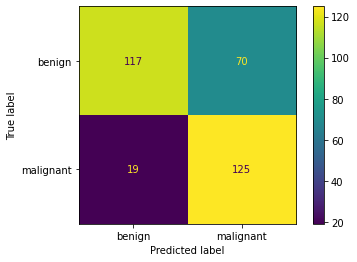

In [ ]:
cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['benign', 'malignant'])
disp.plot()

# Visualize Exaplainability Methods

## Class Activations Maps from Basic CNN Model

Load saved CNN model

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks')
path = Path(os.getcwd())

In [ ]:
base_model = resnet34
learn = vision_learner(dls, base_model, 
                       loss_func = CrossEntropyLossFlat(weight = w), 
                       metrics=accuracy) #assumes pretrained

learn_cam = learn.load(path/'models'/'basic_cnn')
model = learn_cam.model
# Generally we want the CAM to be computed from the last convolutional layer 
# in the network.  For Fastai models this will be `learn.model[0][-1][-1]`.
target_layers = [ model[0][-1][-1] ] # this picks the last layer of the body
targets = None # automatically picks highest category for every image

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Mayo test images for visualization

In [ ]:
test_df = df.loc[(df['dataset'] == 'Mayo') & (df['is_valid'])]
test_dl = dls.test_dl(test_df, with_labels=True)
images, labels = test_dl.one_batch()
images_dec = dls.valid.decode((images,))[0]

# Make predictions
preds_cam, _ = learn_cam.get_preds(dl=test_dl)

In [ ]:
# Function for visualizing CAMs
def output_cam(learner, target_layers, targets, image, denorm_image, cam_name, 
               aug_smooth=True, eigen_smooth=True):
    # takes an image (and its denormalized version)
    # returns array representation of cam on image
    
    # HiResCAM not guaranteed with smoothing
    if cam_name.__name__ == 'HiResCAM':
        aug_smooth = False
        eigen_smooth=False    
    cam = cam_name(model=learner.model, target_layers=target_layers, 
                   use_cuda=True)

    heatmap = cam(input_tensor=image.unsqueeze(0), targets=targets, 
                  aug_smooth=aug_smooth, eigen_smooth=eigen_smooth)
    original = denorm_image.squeeze()
    
    pred_label = learner.predict(denorm_image)[0]

    # permute original to format for plotting
    return original.permute(1,2,0), heatmap[0], pred_label, cam_name.__name__

Visualize CAMs
- Change `list_of_cams` to see different methods

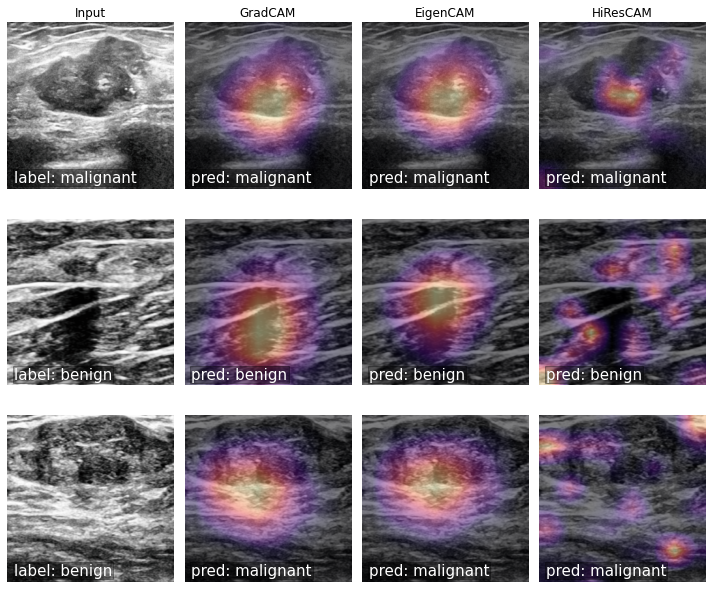

In [ ]:
num_imgs = 3

# Choose out of: GradCAM, GradCAMPlusPlus, HiResCAM, EigenCAM, EigenGradCAM, FullGrad
list_of_cams = [GradCAM, EigenCAM, HiResCAM]
num_cams = len(list_of_cams)
np.random.seed(2)
# show random selection from Mayo valid set
image_idx = np.random.choice(len(images), num_imgs) 

fig, axs = plt.subplots(nrows=num_imgs, ncols=num_cams+1, figsize=(10, 10), 
                        sharex=True, sharey=True, tight_layout=True,
                        subplot_kw={'xticks': [], 'yticks': []})

for row, img in enumerate(image_idx):

    # plot input image for each row
    axs[row,0].imshow(images_dec[img].permute(1,2,0))
    axs[row,0].text(10,250,'label: '+test_dl.vocab[labels[img]],
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
    if row == 0:
        axs[row,0].set_title('Input')
    axs[row,0].axis("off")

    # plot cams for each row and column
    for col, cam_type in enumerate(list_of_cams, start=1):
        og, cam, pred, name = output_cam(learn_cam, target_layers, targets, 
                                         images[img], images_dec[img], cam_type)

        axs[row,col].imshow(og)
        axs[row,col].imshow(cam,alpha=0.5, interpolation='bilinear', 
                            cmap='magma')
        axs[row,col].text(10,250,'pred: '+pred,
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
        if row == 0:
            axs[row,col].set_title(name)
        axs[row,col].axis("off")

fig.savefig("compare_cams.png")

## Saliency Maps from Saliency Model

In [ ]:
# re-define Saliency Model
class SaliencyModel(nn.Module):
    """
    Creates a saliency map model with the encoder from "arch" 
    and with dropout multiplier ps.
    """
    def __init__(self, arch,ps=0.5, percent_t = 0.05):
        super(SaliencyModel,self).__init__()
        # fastai function that creates an encoder given an architecture
        self.encoder = create_body(arch,pretrained=True)  
        self.percent_t = percent_t
        nf = num_features_model(nn.Sequential(*self.encoder.children()))
        # Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
        self.conv_last = nn.Conv2d( nf, 2, (1,1), bias = False) 

    def forward(self,x):
        # apply the base convolutional nn to 
        # convert image 1 x H x W  (e.g. 1 x 256 x 256)
        # to feature map C x h x w (e.g. 512 x 8 x 8 )
        x = self.encoder(x)

        # for each possible classification label take a weighted average of 
        # the C features and apply sigmoid to produce a saliency map that will
        # be 1 x h x w
        cam = self.conv_last(x).sigmoid()
        self.saliency_map = cam
        batch_size, num_class, H, W = cam.size()

        # use Wildcat pooling to average the top t percent of the pixels in the
        # saliency map to a single number for prediction
        # do this for each of the possible classes.  
        # If t = 100% this is GAP.  
        # If t = 100*(1/(h*w)) we get one pixel and this is GMP.
        cam_flatten = cam.view(batch_size, num_class, -1)
        top_t = int(round(W*H*self.percent_t))
        selected_area = cam_flatten.topk(top_t, dim=2)[0]
        return selected_area.mean(dim=2).squeeze()

# The regularization term |A| is model.saliency_maps.mean()
class L1RegCallback(Callback):
    def __init__(self, reglambda = 0.01):
        self.reglambda = reglambda
        
    def after_loss(self):
        self.learn.loss += self.reglambda * self.learn.model.saliency_map.mean()

Load saved Saliency models (with and without L1 Regularization

In [ ]:
base_model_saliency = SaliencyModel(resnet34()).cuda()
learn = Learner(dls, base_model_saliency, metrics = accuracy, cbs = [L1RegCallback()])
learn_saliency_L1 = learn.load(path/'models'/'saliency_model_L1')

In [ ]:
base_model_saliency = SaliencyModel(resnet34()).cuda()
learn = Learner(dls, base_model_saliency, metrics = accuracy, cbs = [L1RegCallback(reglambda=0)])
learn_saliency = learn.load(path/'models'/'saliency_model')

Mayo test images for visualization - same for Basic CNN

In [ ]:
test_df = df.loc[(df['dataset'] == 'Mayo') & (df['is_valid'])]
test_dl = dls.test_dl(test_df, with_labels=True)
images, labels = test_dl.one_batch()
images_dec = dls.valid.decode((images,))[0]

# Make predictions
preds_saliency, _ = learn_saliency.get_preds(dl=test_dl)
preds_saliency_L1, _ = learn_saliency_L1.get_preds(dl=test_dl)

Visualize Saliency Maps with and without L1 Regularization

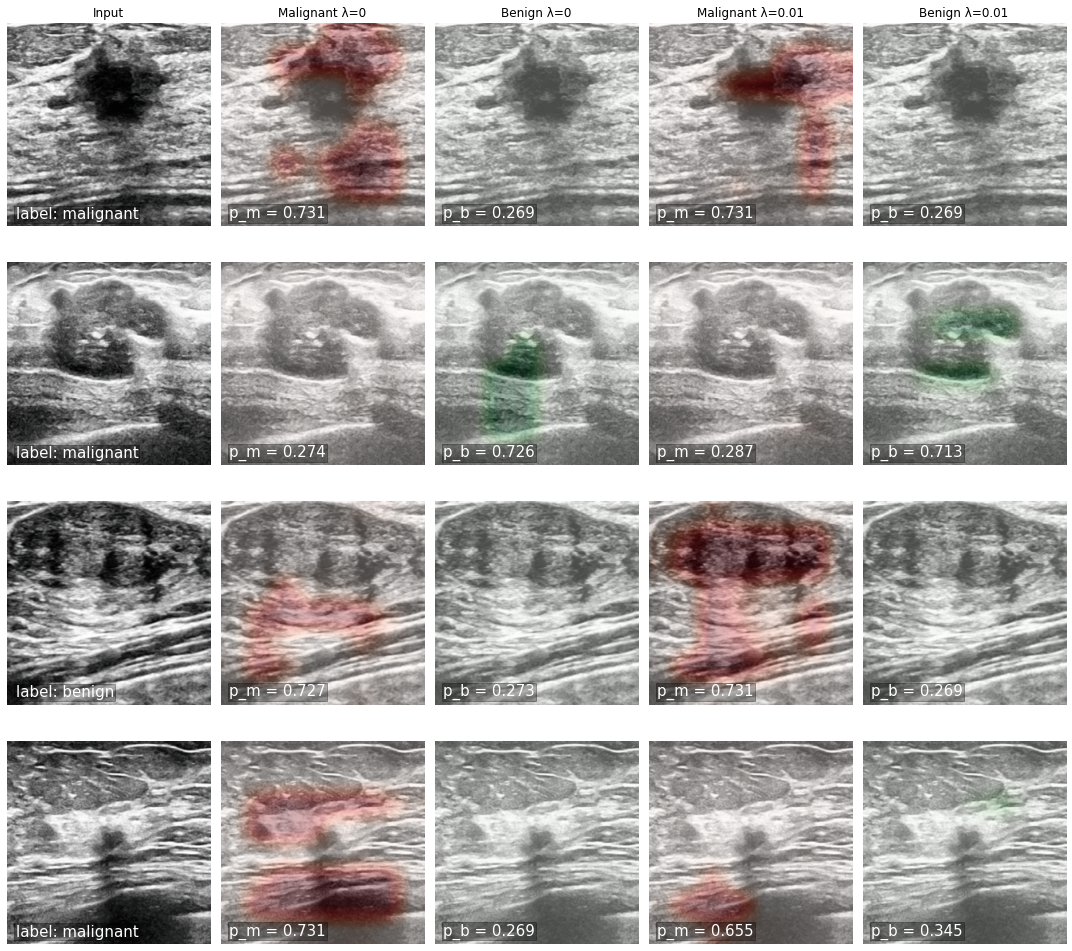

In [ ]:
num_imgs = 4
image_idx = [27,39,44,46]

fig, axs = plt.subplots(nrows=num_imgs, ncols=5, figsize=(15, 15), 
                        sharex=True, sharey=True, tight_layout=True,
                        subplot_kw={'xticks': [], 'yticks': []})

for row, img in enumerate(image_idx):

    # plot input image for each row
    axs[row,0].imshow(images_dec[img].permute(1,2,0))
    axs[row,0].text(10,250,'label: '+test_dl.vocab[labels[img]],
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
    if row == 0:
        axs[row,0].set_title('Input')
    axs[row,0].axis("off")

    # plot saliency maps for each row
    image = images_dec[img].squeeze()

    C, H, W = image.size()

    truth = 'Benign' if int(labels[img])==0 else 'Malignant'

    alphas = np.abs(np.linspace(0,0.95,259))
    alpha_red = plt.cm.get_cmap('Reds')
    alpha_green = plt.cm.get_cmap('Greens')    
    
    # maps without L1
    mal_saliency_map = learn_saliency.model.saliency_map[img,1].squeeze().cpu()
    ben_saliency_map = learn_saliency.model.saliency_map[img,0].squeeze().cpu()
    
    prob_malig = preds_saliency[img,1]
    prob_benign = preds_saliency[img,0]
    malig_str = f'p_m = {prob_malig:0.3f}'
    benign_str = f'p_b = {prob_benign:0.3f}'

    # malignant localization
    axs[row,1].imshow(image.permute(1,2,0),cmap="Greys_r")
    axs[row,1].text(10,250,malig_str,
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
    axs[row,1].imshow(
        cv2.resize(
            mal_saliency_map.numpy(), (H,W)), alpha=0.3, 
            cmap=alpha_red, clim=[0.0, 1.0])
    if row == 0:
        axs[row,1].set_title('Malignant λ=0')
    axs[row,1].axis("off")
    
    # benign localization
    axs[row,2].imshow(image.permute(1,2,0),cmap="Greys_r")
    axs[row,2].text(10,250,benign_str,
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
    axs[row,2].imshow(
        cv2.resize(
            ben_saliency_map.numpy(), (H,W)), alpha=0.3, 
            cmap=alpha_green, clim=[0.0, 1.0])
    if row == 0:
        axs[row,2].set_title('Benign λ=0')
    axs[row,2].axis("off")

    # maps with L1
    mal_saliency_map_L1 = learn_saliency_L1.model.saliency_map[img,1].squeeze().cpu()
    ben_saliency_map_L1 = learn_saliency_L1.model.saliency_map[img,0].squeeze().cpu()

    prob_malig_L1 = preds_saliency_L1[img,1]
    prob_benign_L1 = preds_saliency_L1[img,0]
    malig_str_L1 = f'p_m = {prob_malig_L1:0.3f}'
    benign_str_L1 = f'p_b = {prob_benign_L1:0.3f}'

    # malignant localization
    axs[row,3].imshow(image.permute(1,2,0),cmap="Greys_r")
    axs[row,3].text(10,250,malig_str_L1,
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
    axs[row,3].imshow(
        cv2.resize(
            mal_saliency_map_L1.numpy(), (H,W)), alpha=0.3, 
            cmap=alpha_red, clim=[0.0, 1.0])
    if row == 0:
        axs[row,3].set_title('Malignant λ=0.01')
    axs[row,3].axis("off")
    
    # benign localization
    axs[row,4].imshow(image.permute(1,2,0),cmap="Greys_r")
    axs[row,4].text(10,250,benign_str_L1,
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
    axs[row,4].imshow(
        cv2.resize(
            ben_saliency_map_L1.numpy(), (H,W)), alpha=0.3, 
            cmap=alpha_green, clim=[0.0, 1.0])
    if row == 0:
        axs[row,4].set_title('Benign λ=0.01')
    axs[row,4].axis("off")

fig.savefig("saliency_compare_lambda.png")

## Attention Map-Enhanced CAMs from TransCAM following guide from TransCAM Paper

In [ ]:
# Functions to plot heatmaps for each class (0=benign, 1=malignant)
def visualize_img(img_path, label=None):
    orig_img = np.asarray(Image.open(img_path).convert("RGB"))
    orig_img_size = orig_img.shape[:2]
    img = transform(Image.open(img_path).convert("RGB"))
    logits_conv, logits_trans, cams = model('transcam', img.unsqueeze(0).cuda())
    cams = F.interpolate(cams, orig_img_size, mode='bilinear', align_corners=False).detach()
    cams = cams.cpu().numpy()[0]
    cams[cams < 0] = 0
    cam_max = np.max(cams, (1, 2), keepdims=True)
    cam_min = np.min(cams, (1, 2), keepdims=True)
    norm_cam = (cams - cam_min) / (cam_max - cam_min + 1e-5)
    cam = norm_cam[label]
    return visualize(cam, orig_img)

def visualize(normalized_heatmap, original=None):
    map_img = np.uint8(normalized_heatmap * 255)
    heatmap_img = cv2.applyColorMap(map_img, cv2.COLORMAP_JET)
    if original is not None:
        original_img = cv2.cvtColor(original, cv2.COLOR_RGB2BGR)
        img = cv2.addWeighted(heatmap_img, .6, original_img, 0.4, 0)
    else:
        img = heatmap_img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img 

In [ ]:
test_mayo = df[(df['dataset'] == 'Mayo') & (df['is_valid'] == True)]

In [ ]:
model = Net_sm()
model.load_state_dict(torch.load(path/'models'/'TransCAM_multilabel_cross_entropy.pth')) ##
model = model.cuda()
model.eval()

# ImageNet mean and std for Normalize
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.RandomResizedCrop(256,scale=(0.8,0.8))
                           ])

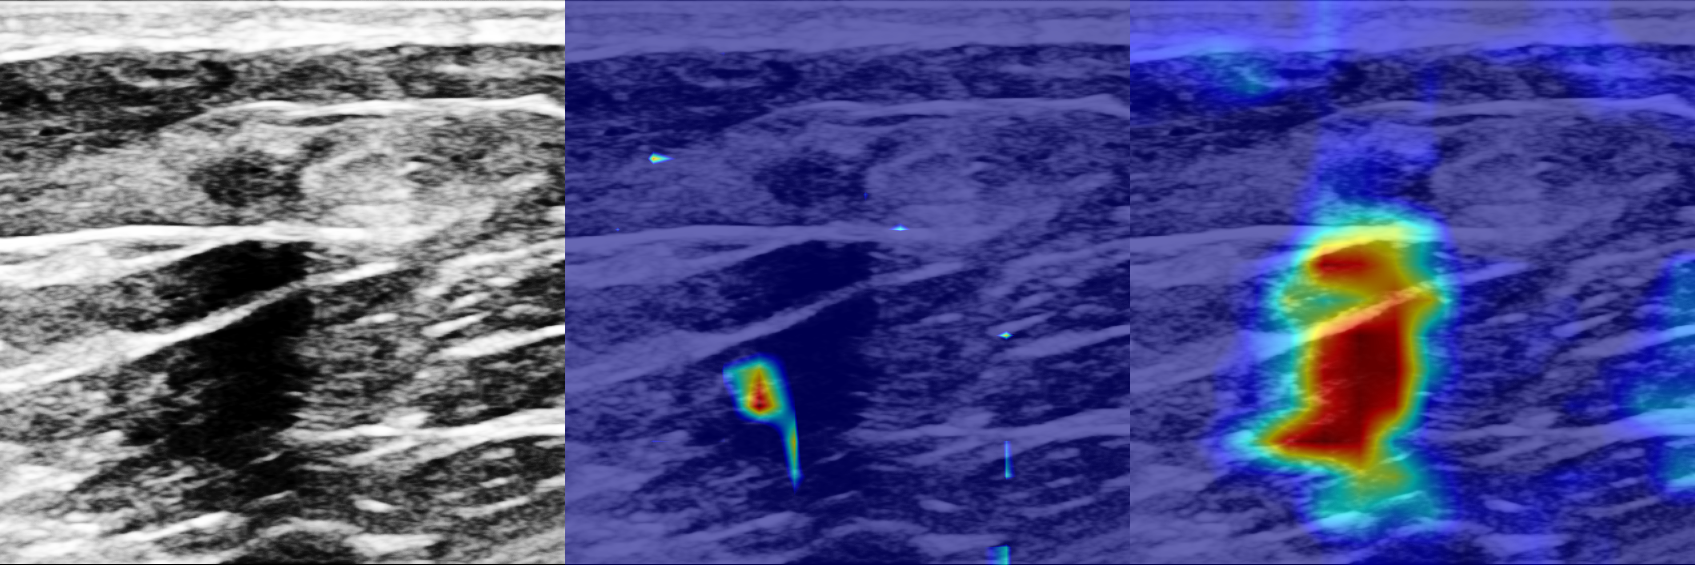

In [ ]:
ii = 15

img_path = test_mayo.iloc[ii,1]
original_img = cv2.cvtColor(np.asarray(Image.open(img_path).convert("RGB")), cv2.COLOR_RGB2BGR)
img_mal = visualize_img(img_path, 1)
img_ben = visualize_img(img_path, 0)
h_array = np.hstack((original_img, img_mal, img_ben))
Image.fromarray(h_array)

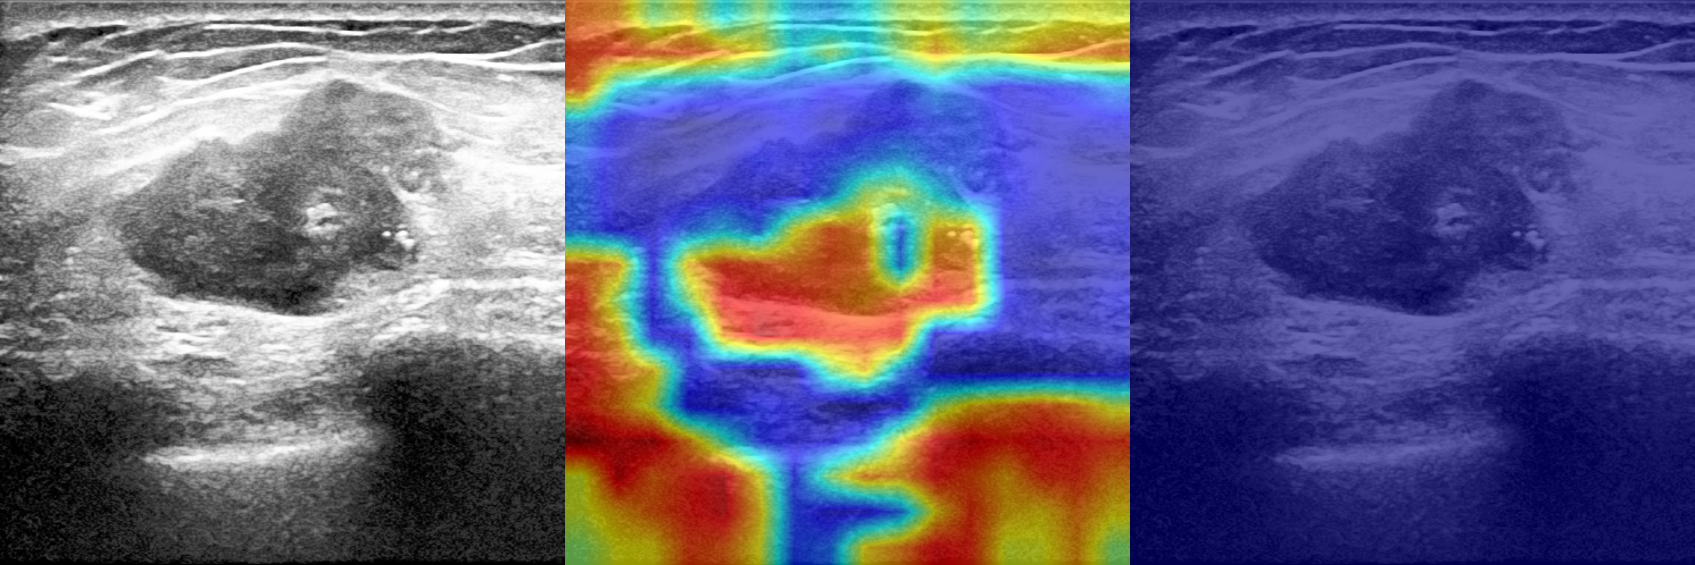

In [ ]:
ii = 40

img_path = test_mayo.iloc[ii,1]
original_img = cv2.cvtColor(np.asarray(Image.open(img_path).convert("RGB")), cv2.COLOR_RGB2BGR)
img_mal = visualize_img(img_path, 1)
img_ben = visualize_img(img_path, 0)
h_array = np.hstack((original_img, img_mal, img_ben))
Image.fromarray(h_array)

## Visualize predictions from CNN and Saliency
Use best CAM techniques and saliency maps produced by Saliency model

Can specify which CAMS to visualize by changing `list_of_cams`

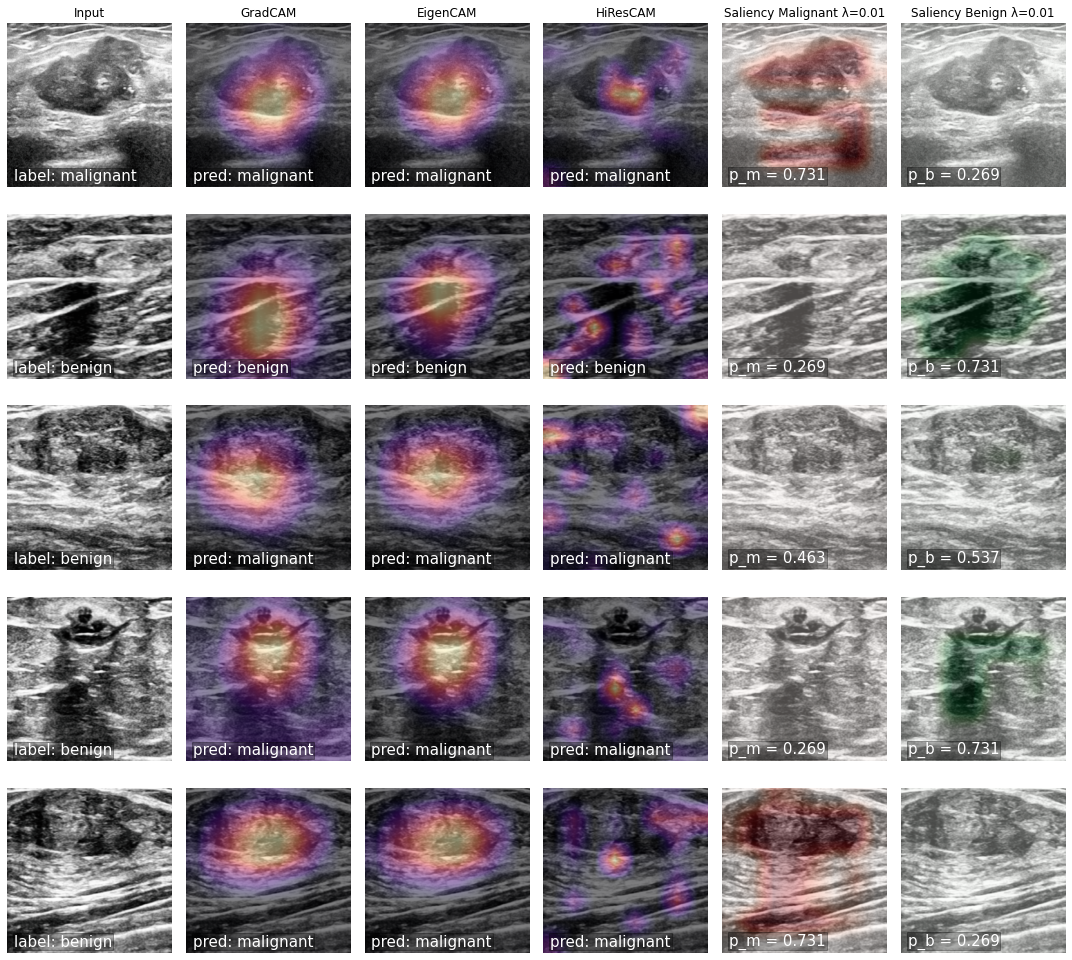

In [ ]:
num_imgs = 5

list_of_cams = [GradCAM, EigenCAM, HiResCAM]
num_cams = len(list_of_cams)
np.random.seed(2)
# show random selection from Mayo valid set
image_idx = np.random.choice(len(images), num_imgs) 

fig, axs = plt.subplots(nrows=num_imgs, ncols=num_cams+3, figsize=(15, 15), 
                        sharex=True, sharey=True, tight_layout=True,
                        subplot_kw={'xticks': [], 'yticks': []})

for row, img in enumerate(image_idx):

    # plot input image for each row
    axs[row,0].imshow(images_dec[img].permute(1,2,0))
    axs[row,0].text(10,250,'label: '+test_dl.vocab[labels[img]],
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
    if row == 0:
        axs[row,0].set_title('Input')
    axs[row,0].axis("off")

    # plot cams for each row and column
    for col, cam_type in enumerate(list_of_cams, start=1):
        og, cam, pred, name = output_cam(learn_cam, target_layers, targets, 
                                         images[img], images_dec[img], cam_type)

        axs[row,col].imshow(og)
        axs[row,col].imshow(cam,alpha=0.5, interpolation='bilinear', 
                            cmap='magma')
        axs[row,col].text(10,250,'pred: '+pred,
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
        if row == 0:
            axs[row,col].set_title(name)
        axs[row,col].axis("off")

    # plot saliency maps for each row
    image = images_dec[img].squeeze()

    C, H, W = image.size()

    mal_saliency_map = learn_saliency_L1.model.saliency_map[img,1].squeeze().cpu()
    ben_saliency_map = learn_saliency_L1.model.saliency_map[img,0].squeeze().cpu()

    truth = 'Benign' if int(labels[img])==0 else 'Malignant'
    prob_benign = preds_saliency_L1[img,0]
    prob_malig = preds_saliency_L1[img,1]
    malig_str = f'p_m = {prob_malig:0.3f}'
    benign_str = f'p_b = {prob_benign:0.3f}'

    alphas = np.abs(np.linspace(0,0.95,259))
    alpha_red = plt.cm.get_cmap('Reds')
    alpha_green = plt.cm.get_cmap('Greens')

    # malignant localization
    axs[row,num_cams+1].imshow(image.permute(1,2,0),cmap="Greys_r")
    axs[row,num_cams+1].text(10,250,malig_str,
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
    axs[row,num_cams+1].imshow(
        cv2.resize(
            mal_saliency_map.numpy(), (H,W)), alpha=0.3, 
            cmap=alpha_red, clim=[0.0, 1.0])
    if row == 0:
        axs[row,num_cams+1].set_title('Saliency Malignant λ=0.01')
    axs[row,num_cams+1].axis("off")
    
    # benign localization
    axs[row,num_cams+2].imshow(image.permute(1,2,0),cmap="Greys_r")
    axs[row,num_cams+2].text(10,250,benign_str,
        verticalalignment='bottom', horizontalalignment='left',
        color='white', fontsize=15, 
        bbox={'facecolor': 'black', 'alpha': 0.3, 'pad': 1})
    axs[row,num_cams+2].imshow(
        cv2.resize(
            ben_saliency_map.numpy(), (H,W)), alpha=0.3, 
            cmap=alpha_green, clim=[0.0, 1.0])
    if row == 0:
        axs[row,num_cams+2].set_title('Saliency Benign λ=0.01')
    axs[row,num_cams+2].axis("off")

fig.savefig("compare_cam_and_saliency.png")